# Image Classification with CNN using Keras

# Task 1: Import Libraries

In [1]:
import tensorflow as tf
import os
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

if not os.path.isdir('models'):
    os.mkdir('models')
    
print('TensorFlow version:', tf.__version__)
print('Is using GPU?', tf.test.is_gpu_available())

TensorFlow version: 2.0.1
Is using GPU? False


# Task 2: Preprocess Data

In [2]:
# The CiFAR-10 dataset has 10 classes and 60k images
# Here only 3 classes are used and only 15k images
def get_three_classes(x, y):
    indices_0, _ = np.where(y == 0.)
    indices_1, _ = np.where(y == 1.)
    indices_2, _ = np.where(y == 2.)

    indices = np.concatenate([indices_0, indices_1, indices_2], axis=0)
    
    # eg and labels corresponding to those indices
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    # shuffle the indices so they're not in a sequence
    indices = np.random.choice(range(count), count, replace=False)
    #.....................List 0 to count-1, no. of choices, random but unique
    
    x = x[indices]
    y = y[indices]
    
    # convert the labels to 1-hot encoded vec
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [4]:
(x_train,y_train), (x_test,y_test) = tf.keras.datasets.cifar10.load_data()
x_train, y_train = get_three_classes(x_train, y_train)
x_test, y_test = get_three_classes(x_test, y_test)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(15000, 32, 32, 3) (15000, 3)
(3000, 32, 32, 3) (3000, 3)


# Task 3: Visualize Examples

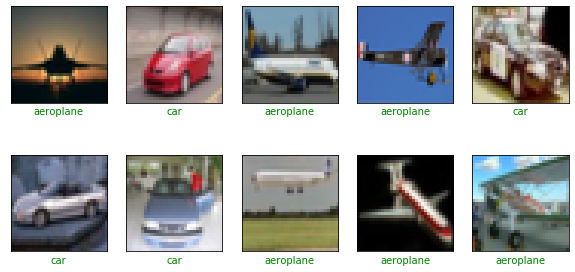

In [11]:
class_names = ['aeroplane', 'car', 'bird']

def show_random_eg(x,y,p):
    indices = np.random.choice(range(x.shape[0]),10, replace=False)
    x=x[indices]
    y=y[indices]
    p=p[indices]
    
    plt.figure(figsize=(10,5))
    for i in range(10):
        plt.subplot(2,5,1+i)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        
        # Right predictions will be in green and wrong will be in red
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names[np.argmax(p[i])], color=col)
    plt.show()

show_random_eg(x_train, y_train, y_train)     
# We don't have predictions yet, hence we're sending the ground truth again

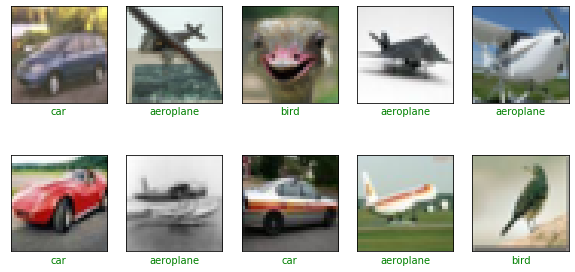

In [12]:
show_random_eg(x_test, y_test, y_test)     
# We don't have predictions yet, hence same case as above

# Task 4: Create Model

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

# Task 5: Train the Model

# Task 6: Final Predictions